<a href="https://colab.research.google.com/github/YeongChaeYun7/DeepLearning/blob/main/v10_Vegetable_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v10

목표  
CNN 모델만들어 이미지 분류  


---
CNN 이론 이해  
텐서플로로 구현하여 CNN의 동작과정을 이해하고자 한다  


---
데이터셋  

채소모음 https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition  
colab과 kaggle 연동하여 업로드  



In [ ]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.utils import plot_model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
#colab과 Kaggle 연동 및 다운로드
!pip install kaggle  
from google.colab import files  
files.upload()  
!mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/  # Kaggle.json (Kaggle API Token) upload
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list -s english-french   
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition # 참고할 Kaggle API
!unzip englishfrench-translations.zip  
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
ref                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dhruvildave/en-fr-translation-dataset             English-French Translation Dataset                  3GB  2021-02-09 19:27:52           1332         35  1.0              
devicharith/language-translation-englishfrench    Language Translation (English-French)               4MB  2020-04-08 11:35:32           1156         33  0.8235294        
digvijayyadav/frenchenglish                       English to French translations                      6MB  2020-07-27 16:22:20            309         17  1.0              
jannesklaas/frenchenglish-bilingual-pairs         French-English Bilingual Pairs                      6MB 

In [ ]:
# zip 풀기
%cd "/content/"
!unzip -qq "/content/fruit-and-vegetable-image-recognition.zip"

/content


# 데이터셋 데이터 전처리

Image DataGenerator  
이미지를 학습시킬 때 학습데이터의 양이 적을 경우

학습데이터를 조금씩 변형시켜서 학습데이터의 양을 늘리는 방식중에 하나  

감자 이미지를 1 픽셀 옆으로 민다고 고구마 이미지가 되진 않는다.  
회전, 확대, 이동, 반전 등의 효과를 적용해도 감자는 여전히 감자이다.  
하지만 픽셀 데이터 상으로는 완전히 다른 데이터이므로 이 점을 이용해 데이터 증식과 위치이동이나 회전에 대한 학습도 진행할 수 있다  

상하좌우 이동, 확대, 회전, 이미지 늘이기, 가로 뒤집기 등 6가지 버전으로 이미지 증식함

In [ ]:
train_data = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True, # 랜덤 가로 뒤짚기
                                  shear_range=True, # 랜덤으로 이미지 밀어 찌그러트리기
                                  rotation_range=30, #  -30 ~ 30도 범위 랜덤 회전
                                  zoom_range=0.3, # 랜덤 줌 범위 30%
                                  width_shift_range=0.3, # 30% 범위로 좌우 이동
                                  height_shift_range=0.3 # 30% 범위로 상하 이동
                                )

In [ ]:
train_images = train_data.flow_from_directory('/content/train',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 3115 images belonging to 36 classes.


In [ ]:
val_data = ImageDataGenerator(rescale=1/255.)

val_images = val_data.flow_from_directory('/content/validation',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 351 images belonging to 36 classes.


In [ ]:
test_data = ImageDataGenerator(rescale=1/255.)

test_images = test_data.flow_from_directory('/content/test',
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='categorical')

Found 359 images belonging to 36 classes.


# 모델 구성

LesNet101V2를 가져와 학습함.  
이 데이터셋에서 테스트 결과의 accuracy와 일반화 성능, 수렴 속도의 향상 효과를 얻음




In [ ]:
resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(64,64,3))

for layer in resnet_v2.layers:
    layer.trainable = False

base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

데이터셋에 비해 신경망이 너무 딥한것 같아 일부 레이어 동결시킴

전체 레이어의 숫자와 이름 확인 후

In [ ]:
for i, layer in enumerate(resnet_v2.layers):
    print(i,layer.name)

0 input_7
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d_18
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad


In [ ]:
for layer in resnet_v2.layers[350:]:
    layer.trainable = True

base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.903469 to fit



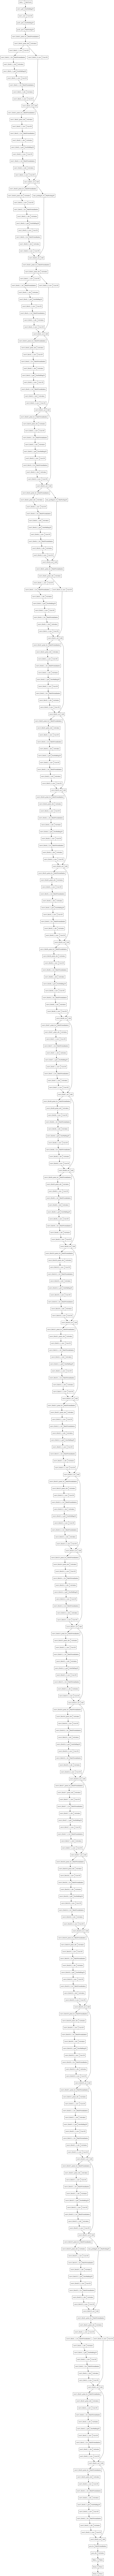

In [ ]:
plot_model(model)

# 훈련
 


In [ ]:
history = model.fit(train_images,
              epochs=100,
              batch_size=32,
              validation_data=val_images)

Epoch 1/100
98/98 [==============================] - 137s 1s/step - loss: 3.3794 - accuracy: 0.1734 - val_loss: 29.8463 - val_accuracy: 0.0883
Epoch 2/100
98/98 [==============================] - 126s 1s/step - loss: 2.4548 - accuracy: 0.3146 - val_loss: 10.4524 - val_accuracy: 0.2422
Epoch 3/100
98/98 [==============================] - 125s 1s/step - loss: 2.1249 - accuracy: 0.4035 - val_loss: 7.5120 - val_accuracy: 0.4302
Epoch 4/100
98/98 [==============================] - 125s 1s/step - loss: 1.9722 - accuracy: 0.4411 - val_loss: 3.1094 - val_accuracy: 0.6866
Epoch 5/100
98/98 [==============================] - 124s 1s/step - loss: 1.8219 - accuracy: 0.4758 - val_loss: 2.1732 - val_accuracy: 0.6952
Epoch 6/100
98/98 [==============================] - 125s 1s/step - loss: 1.7407 - accuracy: 0.4979 - val_loss: 1.7632 - val_accuracy: 0.7094
Epoch 7/100
98/98 [==============================] - 124s 1s/step - loss: 1.6541 - accuracy: 0.5242 - val_loss: 1.4116 - val_accuracy: 0.7493
Epoc

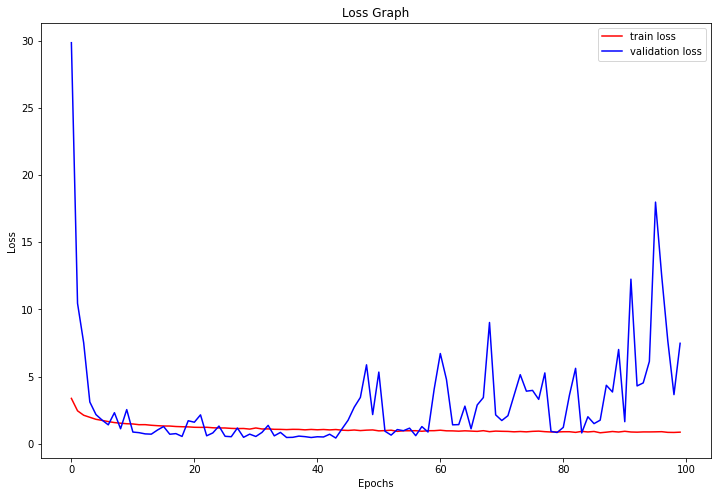

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

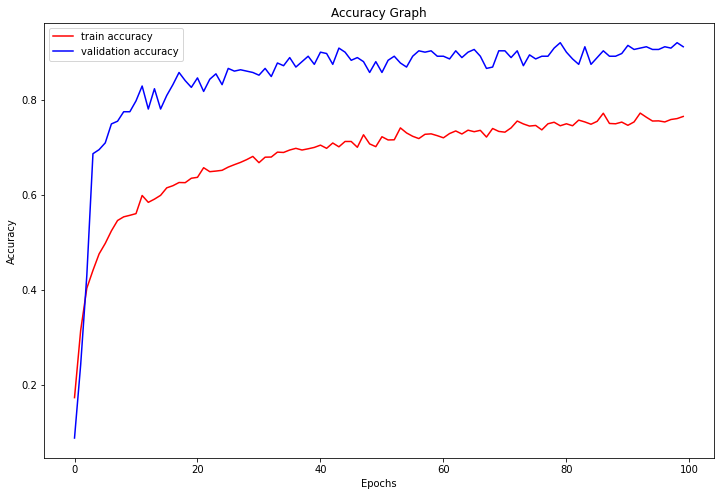

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.evaluate(test_images)

12/12 [==============================] - 17s 1s/step - loss: 7.3117 - accuracy: 0.9136


[7.311724662780762, 0.9136490225791931]

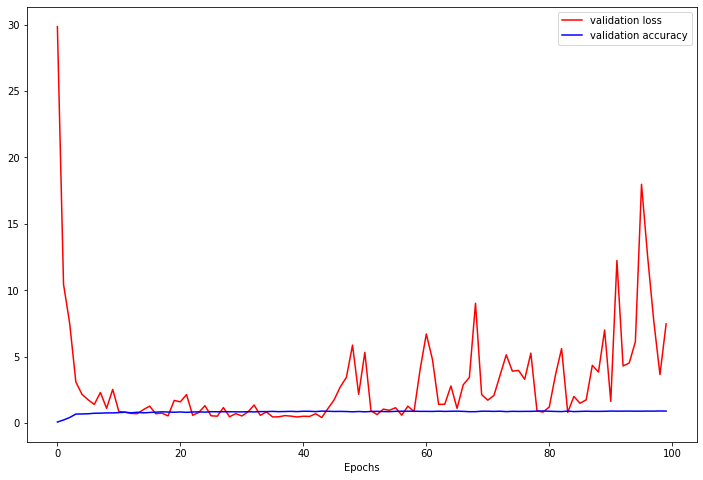

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['val_loss'],'r',label='validation loss')
plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('Epochs')
plt.legend();